# **The Great La Palma Bird Challenge!** 🐦

For this Bird Challenge, we would like you to configure and set up an AudioMoth in a location that you think will capture the greatest number of bird species.

Using the tips in your [Field Guide](https://) you should hopefully have collected data over the past 48 hours which is now ready for analysis.

So let's get started.

### Bioacoustic monitoring

As we have seen earlier, **Bioacoustic sensors** such as AudioMoths, can be used to collect field recordings of animal sounds.

Usually, these sensors are deployed statically in the field for a long periods of time and record sounds continuously. This is called **passive acoustic monitoring**.

<img alt="passive acoustic monitoring" width="400" src="https://wittmann-tours.de/wp-content/uploads/2018/06/AudioMoth.jpg"></img>

Alternatively, recordings are actively directed towards a specific animal species or sound events.

<img alt="active recording" width="400" src="https://s3.amazonaws.com/cdn.freshdesk.com/data/helpdesk/attachments/production/48032687175/original/xjI7Dy3Q9kaCZinr5vf4ksNxQbjK13Yv3A.jpg?1584552543"></img>

> Taken from the Macaulay Library blog post:
> [Sound recording tips](https://support.ebird.org/en/support/solutions/articles/48001064298-sound-recording-tips)

Currently, bioacoustic methods are mainly used for **species presence/absence** detection and can be especially useful for cryptic species detection.

## **Setup**

Make sure to use GPU runtime in Colab.

Go to Runtime -> Change runtime type and select GPU as the hardware accelerator

You'll also need to remember to disconnect the GPU at the end.


#### Mount your Google Drive

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


####We'll install our dependencies here

In [ ]:
!pip install -q birdnetlib
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from datetime import datetime
!pip install -q matplotlib pydub
import os
from os import listdir
from os.path import isfile, join
import random
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.playback import play
from scipy.io import wavfile
from IPython.display import display, HTML, Audio
import librosa
import numpy as np
import soundfile as sf
from tqdm import tqdm
from collections import Counter, defaultdict
import pandas as pd
import librosa.display
import base64

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.7 MB/s eta 0:00:00


#### Link to your audio data folder - the parent folder



In [ ]:
# This specifies the folder
audio_filepath = "https://drive.google.com/drive/folders/1ZavF804nwAegpQVY8ISbQuP-zOzCt0ve?usp=sharing"

# This identifies the audio files in the folder
wav_files = [os.path.join(audio_filepath, file) for file in os.listdir(audio_filepath) if file.endswith('.WAV')]


### Select a random recording from your audio folder and plot a **spectrogram** of it

We can use a **spectrogram** to decompose the sound into **frequencies** and visualise them as a 2D image.

The x-axis is time, y-axis is frequency and the depth of colour represents the amplitude.

In [ ]:
# Select a random file
sample_file = random.choice(wav_files)

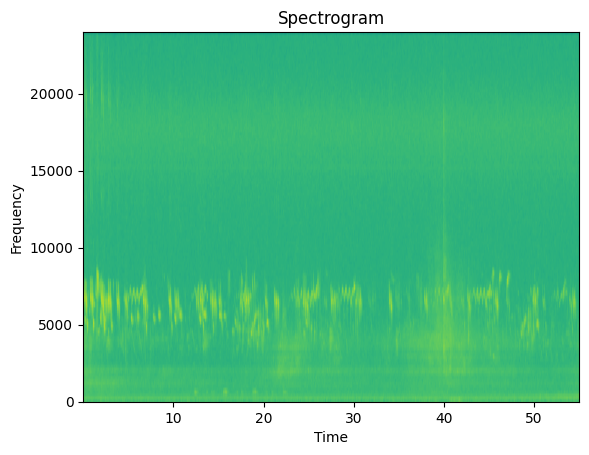

In [ ]:
def plot_spectrogram(audio_file):
    rate, data = wavfile.read(audio_file)
    plt.specgram(data, Fs=rate)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('Spectrogram')
    plt.show()

plot_spectrogram(sample_file)

Spectrograms are used by bioacousticians to quickly spot and identify familiar species **visually**.

Most modern AI detection algorithms used to automatically classify species from animal vocalisations also use spectrograms as their training data. These are primarily Convolutional Neural Networks used in image classification such as reCaptcha forms.



### Let's have a listen

In [ ]:
!Audio(sample_file)

Output hidden; open in https://colab.research.google.com to view.

### Any idea which species are vocalising?

Try to hazard a guess in your groups and record the answer.

If the recording didn't seem to pick up any bird vocalisations then you could re-run the random.choice code to select a new sample and try again.


### Let's see what BirdNet thinks

We're going to run our sample recording via BirdNet which will detect any matching species in each 3 second input and recording a confidence metric for its detection.

BirdNet is a classifier that uses convolutional neural network algorithms to identify wildlife vocalisations in small segments (3 seconds) from longer audio recordings.

BirdNET is able to identify over 3,000 bird species from around the world (Wood et al. 2022).

We typically set a minimum confidence threshold to improve accuracy.


![link text](https://bou.org.uk/wp-content/uploads/2023/03/blog-granados-fig1-600px.jpg)


 BirdNET workflow. Audio recordings are analysed in three second clips and provide an output of species probabilities
 © Cornell Lab of Ornithology (https://birdnet.cornell.edu/).

In [ ]:
# Load and initialize the BirdNET-Analyzer models.
analyzer = Analyzer()

recording = Recording(
    analyzer,
    sample_file,
    lat=51.836010,  # Are these correct for La Palma?
    lon=-0.629810,   # Are these correct for La Palma?
    date=datetime(year=2022, month=5, day=10),  # Use date or week_48
    min_conf=0.2, # feel free to adjust this up or down and see how that affects detections
)
recording.analyze()

# Initialize a string to hold the formatted output
output = "<strong>Detected bird species:</strong><br>"

# Check if there are any detections
if recording.detections:
    # Iterate through detections and format each one
    for idx, detection in enumerate(recording.detections, start=1):
        output += f"<span style='color:green'><strong>{idx}. {detection['common_name']} - {detection['scientific_name']} - Confidence: {detection['confidence']}</strong></span><br>"
else:
    output += "<span style='color:red'><strong>No bird species detected.</strong></span>"

# Display the formatted output using HTML
display(HTML(output))


Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
read_audio_data
read_audio_data: complete, read  18 chunks.
analyze_recording 20240201_074000T.WAV
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
18
140 species loaded.


Did your guess match BirdNET's? **BirdNet** splits the recording into **3 second chunks** and detects species within each chunk. All detections above the minimum confidence threshold (**min_conf**) will be listed.

If you didn't get any detections, try adjusting the min_conf to a lower setting, checking the Lat/Lon coordinates are correct or selecting a new random_sample.

## Onwards to the Challenge!

Now let's import all of the audio files we've collected and run BirdNet on all of them. We'll set the minimum confidence threshold to 0.80 for consistency.

You should start to see some detections popping up in the output as BirdNet processes them all.

This will take some time...check the progress bar for an estimate of exactly how long.

In the meantime, why not take a look at all the birds you could have detected: [Birds of La Palma](https://avibase.bsc-eoc.org/checklist.jsp?region=ESicpa&list=howardmoore)

In [ ]:
def split_audio(audio_file_path, chunk_size=3):
    y, sr = librosa.load(audio_file_path, sr=None)
    chunk_length = sr * chunk_size
    chunks = [y[i:i + chunk_length] for i in range(0, len(y), chunk_length)]
    return chunks, sr

def analyze_chunks(analyzer, chunks, sr, lat, lon, date, audio_filepath, min_conf=0.8):
    results = []
    total_chunks = len(chunks)
    progress_bar = tqdm(total=total_chunks, desc="Processing", unit="chunk")  # Initialize tqdm progress bar

    for i, chunk in enumerate(chunks):
        # Save chunk as WAV file
        chunk_file_path = f'chunk_{i}.wav'
        sf.write(chunk_file_path, chunk, sr)

        # Call BirdNET on the chunk_file_path
        recording = Recording(
            analyzer,
            chunk_file_path,
            lat=lat,
            lon=lon,
            date=date,
            min_conf=min_conf,
        )
        recording.analyze()

        # Append file_path along with detections
        results.append({
            'chunk_number': i,
            'detections': recording.detections,
            'audio_filepath': audio_filepath  # Include audio_filepath in the results
        })

        # Update progress bar
        progress_bar.update(1)  # Update progress bar for each chunk processed

    progress_bar.close()  # Close the tqdm progress bar
    return results

if __name__ == "__main__":

    # Load and initialize the BirdNET-Analyzer models.
    analyzer = Analyzer()

    # Dictionary to store results for each audio file
    all_results = {}

    # Initialize tqdm progress bar
    total_audio_files = len(wav_files)
    progress_bar_total = tqdm(total=total_audio_files, desc="Overall Progress", unit="file")

    for audio_filepath in wav_files:  # Iterate over each audio file path

        # Split audio into chunks
        chunks, sr = split_audio(audio_filepath)

        # Specify location and date information
        lat = 55.3781
        lon = 3.4360
        date = datetime(year=2022, month=5, day=10)

        # Analyze chunks for each audio file
        audio_filename = os.path.basename(audio_filepath)
        all_results[audio_filename] = analyze_chunks(analyzer, chunks, sr, lat, lon, date, audio_filepath)

        # Update progress bar
        progress_bar_total.update(1)  # Update progress bar for each audio file processed

    # Close the tqdm progress bar
    progress_bar_total.close()


Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.



Processing:   5%|▌         | 1/19 [00:00<00:02,  7.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
18
147 species loaded.
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.64chunk/s]

Overall Progress:   0%|          | 1/240 [00:02<10:44,  2.70s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.31chunk/s]

Overall Progress:   1%|          | 2/240 [00:05<11:51,  2.99s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.72chunk/s]

Overall Progress:   1%|▏         | 3/240 [00:08<11:16,  2.86s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.55chunk/s]

Overall Progress:   2%|▏         | 4/240 [00:11<10:48,  2.75s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.35chunk/s]

Overall Progress:   2%|▏         | 5/240 [00:13<10:50,  2.77s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.64chunk/s]

Overall Progress:   2%|▎         | 6/240 [00:16<10:31,  2.70s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  7.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.16chunk/s]

Overall Progress:   3%|▎         | 7/240 [00:19<11:17,  2.91s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.71chunk/s]

Overall Progress:   3%|▎         | 8/240 [00:22<10:57,  2.83s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.68chunk/s]

Overall Progress:   4%|▍         | 9/240 [00:25<10:33,  2.74s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  8.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.49chunk/s]

Overall Progress:   4%|▍         | 10/240 [00:27<10:18,  2.69s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:04,  4.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  8.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:01,  4.90chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:01,  5.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:02<00:00,  5.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  5.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.44chunk/s]

Overall Progress:   5%|▍         | 11/240 [00:31<11:13,  2.94s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  9.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.77chunk/s]

Overall Progress:   5%|▌         | 12/240 [00:33<10:56,  2.88s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.50chunk/s]

Overall Progress:   5%|▌         | 13/240 [00:36<10:33,  2.79s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.63chunk/s]

Overall Progress:   6%|▌         | 14/240 [00:39<10:13,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.67chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.55chunk/s]

Overall Progress:   6%|▋         | 15/240 [00:41<10:10,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.75chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.39chunk/s]

Overall Progress:   7%|▋         | 16/240 [00:45<11:05,  2.97s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.61chunk/s]

Overall Progress:   7%|▋         | 17/240 [00:48<10:47,  2.90s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.78chunk/s]

Overall Progress:   8%|▊         | 18/240 [00:50<10:29,  2.84s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.68chunk/s]

Overall Progress:   8%|▊         | 19/240 [00:53<10:05,  2.74s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:02,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  9.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.43chunk/s]

Overall Progress:   8%|▊         | 20/240 [00:56<10:18,  2.81s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  8.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.52chunk/s]

Overall Progress:   9%|▉         | 21/240 [00:59<10:33,  2.89s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  8.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.56chunk/s]

Overall Progress:   9%|▉         | 22/240 [01:01<10:08,  2.79s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.36chunk/s]

read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.85chunk/s]

Overall Progress:  10%|▉         | 23/240 [01:04<09:54,  2.74s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  9.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.68chunk/s]

Overall Progress:  10%|█         | 24/240 [01:07<09:37,  2.67s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.60chunk/s]

Overall Progress:  10%|█         | 25/240 [01:10<09:56,  2.78s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:01<00:01,  8.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.56chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.55chunk/s]

Overall Progress:  11%|█         | 26/240 [01:12<09:54,  2.78s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  9.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.50chunk/s]

Overall Progress:  11%|█▏        | 27/240 [01:15<09:38,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.70chunk/s]

Overall Progress:  12%|█▏        | 28/240 [01:17<09:22,  2.65s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  6.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:01,  8.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  8.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:02<00:00,  9.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.24chunk/s]

Overall Progress:  12%|█▏        | 29/240 [01:20<09:16,  2.64s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  6.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.80chunk/s]

Overall Progress:  12%|█▎        | 30/240 [01:23<09:56,  2.84s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.80chunk/s]

Overall Progress:  13%|█▎        | 31/240 [01:26<09:43,  2.79s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.56chunk/s]

Overall Progress:  13%|█▎        | 32/240 [01:29<09:24,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.46chunk/s]

Overall Progress:  14%|█▍        | 33/240 [01:31<09:11,  2.66s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.67chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.90chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.41chunk/s]

Overall Progress:  14%|█▍        | 34/240 [01:34<09:11,  2.68s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.75chunk/s]

Overall Progress:  15%|█▍        | 35/240 [01:37<09:50,  2.88s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.77chunk/s]

Overall Progress:  15%|█▌        | 36/240 [01:40<09:24,  2.77s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.69chunk/s]

Overall Progress:  15%|█▌        | 37/240 [01:42<09:07,  2.70s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.90chunk/s]

Overall Progress:  16%|█▌        | 38/240 [01:45<09:12,  2.74s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.56chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  7.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  6.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  6.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.13chunk/s]

Overall Progress:  16%|█▋        | 39/240 [01:48<09:28,  2.83s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  8.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:02<00:00,  9.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.05chunk/s]

Overall Progress:  17%|█▋        | 40/240 [01:51<09:35,  2.88s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.81chunk/s]

Overall Progress:  17%|█▋        | 41/240 [01:54<09:13,  2.78s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.57chunk/s]

Overall Progress:  18%|█▊        | 42/240 [01:56<08:56,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.56chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.35chunk/s]

Overall Progress:  18%|█▊        | 43/240 [01:59<08:54,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.75chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  6.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.08chunk/s]

Overall Progress:  18%|█▊        | 44/240 [02:02<09:22,  2.87s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  7.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.52chunk/s]

Overall Progress:  19%|█▉        | 45/240 [02:05<09:04,  2.79s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.61chunk/s]

Overall Progress:  19%|█▉        | 46/240 [02:07<08:46,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  8.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.01chunk/s]

Overall Progress:  20%|█▉        | 47/240 [02:10<08:45,  2.72s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.59chunk/s]

Overall Progress:  20%|██        | 48/240 [02:13<08:35,  2.69s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.54chunk/s]

Overall Progress:  20%|██        | 49/240 [02:16<09:22,  2.95s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.55chunk/s]

Overall Progress:  21%|██        | 50/240 [02:19<09:05,  2.87s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.62chunk/s]

Overall Progress:  21%|██▏       | 51/240 [02:21<08:44,  2.78s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  9.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.70chunk/s]

Overall Progress:  22%|██▏       | 52/240 [02:24<08:42,  2.78s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  6.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.12chunk/s]

Overall Progress:  22%|██▏       | 53/240 [02:27<08:56,  2.87s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  8.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.81chunk/s]

Overall Progress:  22%|██▎       | 54/240 [02:30<09:01,  2.91s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.63chunk/s]

Overall Progress:  23%|██▎       | 55/240 [02:33<08:44,  2.84s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.76chunk/s]

Overall Progress:  23%|██▎       | 56/240 [02:36<08:34,  2.80s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.46chunk/s]

Overall Progress:  24%|██▍       | 57/240 [02:38<08:18,  2.72s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  6.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.85chunk/s]

Overall Progress:  24%|██▍       | 58/240 [02:41<08:48,  2.90s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.93chunk/s]

Overall Progress:  25%|██▍       | 59/240 [02:44<08:34,  2.84s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.29chunk/s]

Overall Progress:  25%|██▌       | 60/240 [02:47<08:24,  2.80s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.58chunk/s]

Overall Progress:  25%|██▌       | 61/240 [02:50<08:25,  2.82s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  7.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.77chunk/s]

Overall Progress:  26%|██▌       | 62/240 [02:53<08:26,  2.85s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  7.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.00chunk/s]

Overall Progress:  26%|██▋       | 63/240 [02:56<08:46,  2.98s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:01,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  8.75chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.34chunk/s]

Overall Progress:  27%|██▋       | 64/240 [02:59<08:22,  2.85s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.64chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.06chunk/s]

Overall Progress:  27%|██▋       | 65/240 [03:01<08:08,  2.79s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.51chunk/s]

Overall Progress:  28%|██▊       | 66/240 [03:04<07:51,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  6.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.05chunk/s]

Overall Progress:  28%|██▊       | 67/240 [03:07<07:55,  2.75s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  8.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:02<00:00,  9.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.67chunk/s]

Overall Progress:  28%|██▊       | 68/240 [03:10<08:06,  2.83s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  9.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.63chunk/s]

Overall Progress:  29%|██▉       | 69/240 [03:12<07:51,  2.76s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.10chunk/s]

Overall Progress:  29%|██▉       | 70/240 [03:15<07:40,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.65chunk/s]

Overall Progress:  30%|██▉       | 71/240 [03:17<07:27,  2.65s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.30chunk/s]

Overall Progress:  30%|███       | 72/240 [03:20<07:53,  2.82s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.54chunk/s]

Overall Progress:  30%|███       | 73/240 [03:23<07:46,  2.79s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:02<00:00,  8.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.35chunk/s]

Overall Progress:  31%|███       | 74/240 [03:26<07:29,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  7.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:01<00:01,  8.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:01,  8.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  8.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  8.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.79chunk/s]

Overall Progress:  31%|███▏      | 75/240 [03:28<07:24,  2.69s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  9.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.48chunk/s]

Overall Progress:  32%|███▏      | 76/240 [03:31<07:23,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.39chunk/s]

Overall Progress:  32%|███▏      | 77/240 [03:35<08:00,  2.94s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.75chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.17chunk/s]

Overall Progress:  32%|███▎      | 78/240 [03:37<07:38,  2.83s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.33chunk/s]

Overall Progress:  33%|███▎      | 79/240 [03:40<07:26,  2.78s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.42chunk/s]

Overall Progress:  33%|███▎      | 80/240 [03:42<07:11,  2.70s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.56chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.98chunk/s]

Overall Progress:  34%|███▍      | 81/240 [03:45<07:05,  2.68s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.55chunk/s]

Overall Progress:  34%|███▍      | 82/240 [03:48<07:37,  2.90s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:01<00:00,  9.63chunk/s]

Overall Progress:  35%|███▍      | 83/240 [03:51<07:21,  2.82s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  7.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:02<00:00,  9.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.98chunk/s]

Overall Progress:  35%|███▌      | 84/240 [03:54<07:09,  2.75s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  9.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.28chunk/s]

Overall Progress:  35%|███▌      | 85/240 [03:56<07:04,  2.74s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  6.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.82chunk/s]

Overall Progress:  36%|███▌      | 86/240 [03:59<07:07,  2.78s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.65chunk/s]

Overall Progress:  36%|███▋      | 87/240 [04:02<07:21,  2.89s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.64chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.49chunk/s]

Overall Progress:  37%|███▋      | 88/240 [04:05<06:58,  2.75s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:02<00:00,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.43chunk/s]

Overall Progress:  37%|███▋      | 89/240 [04:07<06:43,  2.67s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.44chunk/s]

Overall Progress:  38%|███▊      | 90/240 [04:10<06:43,  2.69s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.36chunk/s]

Overall Progress:  38%|███▊      | 91/240 [04:13<06:58,  2.81s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  8.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.67chunk/s]

Overall Progress:  38%|███▊      | 92/240 [04:16<07:02,  2.86s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  9.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  7.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.87chunk/s]

Overall Progress:  39%|███▉      | 93/240 [04:19<06:52,  2.81s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  9.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:00<00:01,  8.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.37chunk/s]

Overall Progress:  39%|███▉      | 94/240 [04:21<06:36,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.40chunk/s]

Overall Progress:  40%|███▉      | 95/240 [04:24<06:25,  2.66s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  6.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.89chunk/s]

Overall Progress:  40%|████      | 96/240 [04:27<06:49,  2.84s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:01<00:01,  8.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.59chunk/s]

Overall Progress:  40%|████      | 97/240 [04:30<06:39,  2.79s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.26chunk/s]

Overall Progress:  41%|████      | 98/240 [04:32<06:24,  2.71s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  9.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.39chunk/s]

Overall Progress:  41%|████▏     | 99/240 [04:35<06:19,  2.69s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.90chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.32chunk/s]

Overall Progress:  42%|████▏     | 100/240 [04:37<06:14,  2.67s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  7.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:02,  7.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  8.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  6.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:01<00:01,  6.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:01,  6.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:01,  5.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:01,  5.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:02<00:00,  5.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  5.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  6.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  5.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.57chunk/s]

Overall Progress:  42%|████▏     | 101/240 [04:40<06:22,  2.75s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:01<00:01,  8.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.74chunk/s]

Overall Progress:  42%|████▎     | 102/240 [04:43<06:16,  2.73s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.84chunk/s]

Overall Progress:  43%|████▎     | 103/240 [04:46<06:27,  2.83s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  9.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.71chunk/s]

Overall Progress:  43%|████▎     | 104/240 [04:49<06:19,  2.79s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.90chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.09chunk/s]

Overall Progress:  44%|████▍     | 105/240 [04:52<06:16,  2.79s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.60chunk/s]

Overall Progress:  44%|████▍     | 106/240 [04:55<06:35,  2.95s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.20chunk/s]

Overall Progress:  45%|████▍     | 107/240 [04:58<06:24,  2.89s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  9.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  9.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  95%|█████████▍| 18/19 [00:01<00:00,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.45chunk/s]

Overall Progress:  45%|████▌     | 108/240 [05:00<06:15,  2.85s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  9.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.33chunk/s]

Overall Progress:  45%|████▌     | 109/240 [05:03<06:12,  2.84s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.75chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.53chunk/s]

Overall Progress:  46%|████▌     | 110/240 [05:06<06:17,  2.90s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.64chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.79chunk/s]

Overall Progress:  46%|████▋     | 111/240 [05:09<06:15,  2.91s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.25chunk/s]

Overall Progress:  47%|████▋     | 112/240 [05:12<06:06,  2.86s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  21%|██        | 4/19 [00:00<00:01,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  6.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.74chunk/s]

Overall Progress:  47%|████▋     | 113/240 [05:15<05:57,  2.81s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.90chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.56chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.21chunk/s]

Overall Progress:  48%|████▊     | 114/240 [05:17<05:45,  2.74s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  6.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.88chunk/s]

Overall Progress:  48%|████▊     | 115/240 [05:20<05:59,  2.88s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.39chunk/s]

Overall Progress:  48%|████▊     | 116/240 [05:23<05:53,  2.85s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:00,  9.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.27chunk/s]

Overall Progress:  49%|████▉     | 117/240 [05:26<05:41,  2.77s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  9.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.21chunk/s]

Overall Progress:  49%|████▉     | 118/240 [05:28<05:29,  2.70s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  9.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  9.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.25chunk/s]

Overall Progress:  50%|████▉     | 119/240 [05:31<05:26,  2.70s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:01,  5.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  5.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  5.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:03<00:00,  6.18chunk/s]

Overall Progress:  50%|█████     | 120/240 [05:35<05:58,  2.99s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.75chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.11chunk/s]

Overall Progress:  50%|█████     | 121/240 [05:37<05:43,  2.89s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.65chunk/s]

Overall Progress:  51%|█████     | 122/240 [05:40<05:32,  2.82s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.64chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.08chunk/s]

Overall Progress:  51%|█████▏    | 123/240 [05:43<05:21,  2.74s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:00<00:01,  8.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.45chunk/s]

Overall Progress:  52%|█████▏    | 124/240 [05:45<05:18,  2.75s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:01,  5.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.75chunk/s]

Overall Progress:  52%|█████▏    | 125/240 [05:49<05:38,  2.95s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.67chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.96chunk/s]

Overall Progress:  52%|█████▎    | 126/240 [05:51<05:25,  2.86s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.67chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.64chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.06chunk/s]

Overall Progress:  53%|█████▎    | 127/240 [05:54<05:13,  2.78s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.08chunk/s]

Overall Progress:  53%|█████▎    | 128/240 [05:57<05:12,  2.79s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.07chunk/s]

Overall Progress:  54%|█████▍    | 129/240 [06:00<05:20,  2.89s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  8.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.93chunk/s]

Overall Progress:  54%|█████▍    | 130/240 [06:03<05:19,  2.90s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.50chunk/s]

Overall Progress:  55%|█████▍    | 131/240 [06:06<05:09,  2.84s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.98chunk/s]

Overall Progress:  55%|█████▌    | 132/240 [06:08<05:04,  2.82s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.08chunk/s]

Overall Progress:  55%|█████▌    | 133/240 [06:11<04:52,  2.74s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.44chunk/s]

Overall Progress:  56%|█████▌    | 134/240 [06:14<05:11,  2.94s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.01chunk/s]

Overall Progress:  56%|█████▋    | 135/240 [06:17<05:04,  2.90s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.65chunk/s]

Overall Progress:  57%|█████▋    | 136/240 [06:20<04:54,  2.83s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  8.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.67chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.20chunk/s]

Overall Progress:  57%|█████▋    | 137/240 [06:23<04:48,  2.80s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.52chunk/s]

Overall Progress:  57%|█████▊    | 138/240 [06:25<04:42,  2.77s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  5.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.48chunk/s]

Overall Progress:  58%|█████▊    | 139/240 [06:29<04:59,  2.97s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:01<00:00,  7.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.56chunk/s]

Overall Progress:  58%|█████▊    | 140/240 [06:31<04:51,  2.91s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.81chunk/s]

Overall Progress:  59%|█████▉    | 141/240 [06:34<04:41,  2.84s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  11%|█         | 2/19 [00:00<00:01,  9.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.85chunk/s]

Overall Progress:  59%|█████▉    | 142/240 [06:37<04:34,  2.80s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.27chunk/s]

Overall Progress:  60%|█████▉    | 143/240 [06:40<04:39,  2.89s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  8.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.66chunk/s]

Overall Progress:  60%|██████    | 144/240 [06:43<04:43,  2.95s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.56chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.87chunk/s]

Overall Progress:  60%|██████    | 145/240 [06:46<04:37,  2.92s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.70chunk/s]

Overall Progress:  61%|██████    | 146/240 [06:49<04:32,  2.90s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.07chunk/s]

Overall Progress:  61%|██████▏   | 147/240 [06:51<04:21,  2.81s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  5.90chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.37chunk/s]

Overall Progress:  62%|██████▏   | 148/240 [06:55<04:42,  3.07s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:01<00:01,  6.75chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:01,  7.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  7.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  8.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  8.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.44chunk/s]

Overall Progress:  62%|██████▏   | 149/240 [06:58<04:34,  3.01s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.80chunk/s]

Overall Progress:  62%|██████▎   | 150/240 [07:01<04:22,  2.92s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.67chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.75chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.03chunk/s]

Overall Progress:  63%|██████▎   | 151/240 [07:03<04:14,  2.86s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.56chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  6.72chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.89chunk/s]

Overall Progress:  63%|██████▎   | 152/240 [07:06<04:12,  2.87s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:01,  5.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  7.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.67chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.89chunk/s]

Overall Progress:  64%|██████▍   | 153/240 [07:09<04:19,  2.99s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.56chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.92chunk/s]

Overall Progress:  64%|██████▍   | 154/240 [07:12<04:13,  2.95s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.64chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.98chunk/s]

Overall Progress:  65%|██████▍   | 155/240 [07:15<04:00,  2.83s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.67chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:01<00:00,  8.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  9.01chunk/s]

Overall Progress:  65%|██████▌   | 156/240 [07:17<03:51,  2.75s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.85chunk/s]

Overall Progress:  65%|██████▌   | 157/240 [07:21<04:01,  2.90s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:01<00:02,  4.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:01<00:01,  6.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:01,  7.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  7.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:02<00:00,  7.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.27chunk/s]

Overall Progress:  66%|██████▌   | 158/240 [07:24<04:02,  2.96s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.89chunk/s]

Overall Progress:  66%|██████▋   | 159/240 [07:26<03:51,  2.86s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.79chunk/s]

Overall Progress:  67%|██████▋   | 160/240 [07:29<03:44,  2.81s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.64chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.86chunk/s]

Overall Progress:  67%|██████▋   | 161/240 [07:32<03:38,  2.77s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  5.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:01,  5.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  5.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:03<00:00,  6.22chunk/s]

Overall Progress:  68%|██████▊   | 162/240 [07:35<03:55,  3.02s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.46chunk/s]

Overall Progress:  68%|██████▊   | 163/240 [07:38<03:44,  2.92s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  7.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.67chunk/s]

Overall Progress:  68%|██████▊   | 164/240 [07:41<03:36,  2.85s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.61chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.76chunk/s]

Overall Progress:  69%|██████▉   | 165/240 [07:43<03:28,  2.78s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.70chunk/s]

Overall Progress:  69%|██████▉   | 166/240 [07:46<03:22,  2.74s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.75chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:01<00:02,  5.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:01,  5.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:02<00:01,  5.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:02<00:00,  5.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  5.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:03<00:00,  5.95chunk/s]

Overall Progress:  70%|██████▉   | 167/240 [07:50<03:39,  3.01s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.57chunk/s]

Overall Progress:  70%|███████   | 168/240 [07:52<03:32,  2.95s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.90chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.42chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.72chunk/s]

Overall Progress:  70%|███████   | 169/240 [07:55<03:23,  2.86s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.53chunk/s]

Overall Progress:  71%|███████   | 170/240 [07:58<03:21,  2.88s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.56chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  5.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  5.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.99chunk/s]

Overall Progress:  71%|███████▏  | 171/240 [08:01<03:26,  2.99s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  8.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.69chunk/s]

Overall Progress:  72%|███████▏  | 172/240 [08:05<03:28,  3.07s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.71chunk/s]

Overall Progress:  72%|███████▏  | 173/240 [08:07<03:22,  3.02s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.64chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.71chunk/s]

Overall Progress:  72%|███████▎  | 174/240 [08:10<03:11,  2.90s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.77chunk/s]

Overall Progress:  73%|███████▎  | 175/240 [08:13<03:08,  2.89s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  5.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:03<00:00,  6.24chunk/s]

Overall Progress:  73%|███████▎  | 176/240 [08:16<03:16,  3.07s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  6.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  7.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.21chunk/s]

Overall Progress:  74%|███████▍  | 177/240 [08:19<03:07,  2.98s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  7.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.43chunk/s]

Overall Progress:  74%|███████▍  | 178/240 [08:22<02:59,  2.89s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.63chunk/s]

Overall Progress:  75%|███████▍  | 179/240 [08:25<02:56,  2.89s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  6.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.55chunk/s]

Overall Progress:  75%|███████▌  | 180/240 [08:28<02:55,  2.92s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.45chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  7.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.95chunk/s]

Overall Progress:  75%|███████▌  | 181/240 [08:31<02:58,  3.03s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.64chunk/s]

Overall Progress:  76%|███████▌  | 182/240 [08:34<02:53,  3.00s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.59chunk/s]

Overall Progress:  76%|███████▋  | 183/240 [08:37<02:44,  2.89s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.40chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.47chunk/s]

Overall Progress:  77%|███████▋  | 184/240 [08:39<02:38,  2.84s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  7.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.63chunk/s]

Overall Progress:  77%|███████▋  | 185/240 [08:43<02:45,  3.01s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.65chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.80chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  8.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.73chunk/s]

Overall Progress:  78%|███████▊  | 186/240 [08:46<02:45,  3.06s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.58chunk/s]

Overall Progress:  78%|███████▊  | 187/240 [08:49<02:36,  2.96s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.57chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.54chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.18chunk/s]

Overall Progress:  78%|███████▊  | 188/240 [08:51<02:31,  2.92s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.95chunk/s]

Overall Progress:  79%|███████▉  | 189/240 [08:54<02:30,  2.95s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  5.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data

Processing:  53%|█████▎    | 10/19 [00:01<00:01,  5.19chunk/s]


read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:02<00:01,  5.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:02<00:00,  5.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  6.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:03<00:00,  6.10chunk/s]

Overall Progress:  79%|███████▉  | 190/240 [08:58<02:37,  3.16s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  7.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.64chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.46chunk/s]

Overall Progress:  80%|███████▉  | 191/240 [09:01<02:28,  3.03s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.39chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.57chunk/s]

Overall Progress:  80%|████████  | 192/240 [09:04<02:23,  2.99s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.68chunk/s]

Overall Progress:  80%|████████  | 193/240 [09:06<02:15,  2.89s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.93chunk/s]

Overall Progress:  81%|████████  | 194/240 [09:10<02:17,  2.98s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  7.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.54chunk/s]

Overall Progress:  81%|████████▏ | 195/240 [09:13<02:15,  3.02s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  7.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.44chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  6.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  7.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.19chunk/s]

Overall Progress:  82%|████████▏ | 196/240 [09:15<02:09,  2.95s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.37chunk/s]

Overall Progress:  82%|████████▏ | 197/240 [09:18<02:07,  2.96s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.46chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.56chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.99chunk/s]

Overall Progress:  82%|████████▎ | 198/240 [09:21<02:03,  2.93s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.90chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  5.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:01,  5.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  5.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  5.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:03<00:00,  6.13chunk/s]

Overall Progress:  83%|████████▎ | 199/240 [09:25<02:08,  3.13s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.51chunk/s]

Overall Progress:  83%|████████▎ | 200/240 [09:28<02:00,  3.02s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.42chunk/s]

Overall Progress:  84%|████████▍ | 201/240 [09:30<01:54,  2.94s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.47chunk/s]

Overall Progress:  84%|████████▍ | 202/240 [09:34<01:53,  2.98s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  5.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  5.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.95chunk/s]

Overall Progress:  85%|████████▍ | 203/240 [09:37<01:52,  3.05s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  5.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  7.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  7.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.16chunk/s]

Overall Progress:  85%|████████▌ | 204/240 [09:40<01:51,  3.09s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.48chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.50chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.61chunk/s]

Overall Progress:  85%|████████▌ | 205/240 [09:43<01:44,  2.98s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.21chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.22chunk/s]

Overall Progress:  86%|████████▌ | 206/240 [09:46<01:41,  2.99s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.56chunk/s]

Overall Progress:  86%|████████▋ | 207/240 [09:48<01:36,  2.93s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.60chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:01<00:01,  5.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:01,  5.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:02<00:01,  5.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:02<00:00,  5.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  5.52chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:03<00:00,  5.86chunk/s]

Overall Progress:  87%|████████▋ | 208/240 [09:52<01:41,  3.17s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.50chunk/s]

Overall Progress:  87%|████████▋ | 209/240 [09:55<01:34,  3.03s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.34chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.60chunk/s]

Overall Progress:  88%|████████▊ | 210/240 [09:58<01:28,  2.94s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.90chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.40chunk/s]

Overall Progress:  88%|████████▊ | 211/240 [10:01<01:25,  2.95s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.33chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.53chunk/s]

Overall Progress:  88%|████████▊ | 212/240 [10:04<01:23,  2.98s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  5.75chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:00,  6.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  7.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.72chunk/s]

Overall Progress:  89%|████████▉ | 213/240 [10:07<01:23,  3.10s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.08chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.44chunk/s]

Overall Progress:  89%|████████▉ | 214/240 [10:10<01:18,  3.03s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.43chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  32%|███▏      | 6/19 [00:00<00:01,  6.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  42%|████▏     | 8/19 [00:01<00:01,  7.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:01,  7.75chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  8.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  8.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  8.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.22chunk/s]

Overall Progress:  90%|████████▉ | 215/240 [10:13<01:14,  2.98s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.45chunk/s]

Overall Progress:  90%|█████████ | 216/240 [10:16<01:10,  2.94s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:01,  5.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  5.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  5.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.42chunk/s]

Overall Progress:  90%|█████████ | 217/240 [10:19<01:10,  3.07s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  7.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.41chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  7.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.66chunk/s]

Overall Progress:  91%|█████████ | 218/240 [10:22<01:07,  3.09s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:01,  9.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.20chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  8.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.22chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.45chunk/s]

Overall Progress:  91%|█████████▏| 219/240 [10:25<01:03,  3.03s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.04chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.41chunk/s]

Overall Progress:  92%|█████████▏| 220/240 [10:28<00:59,  2.97s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.77chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  6.53chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  5.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.51chunk/s]

Overall Progress:  92%|█████████▏| 221/240 [10:31<00:57,  3.03s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  6.32chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  6.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  6.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  5.81chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:01,  5.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  5.59chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.40chunk/s]

Overall Progress:  92%|█████████▎| 222/240 [10:34<00:56,  3.15s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.09chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.49chunk/s]

Overall Progress:  93%|█████████▎| 223/240 [10:37<00:51,  3.01s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.35chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.27chunk/s]

Overall Progress:  93%|█████████▎| 224/240 [10:40<00:47,  3.00s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  53%|█████▎    | 10/19 [00:01<00:01,  6.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  63%|██████▎   | 12/19 [00:01<00:00,  7.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  7.47chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  7.66chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.95chunk/s]

Overall Progress:  94%|█████████▍| 225/240 [10:43<00:44,  2.98s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  6.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:01,  5.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  6.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  5.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.55chunk/s]

Overall Progress:  94%|█████████▍| 226/240 [10:46<00:43,  3.09s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.55chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.68chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.38chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  7.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.50chunk/s]

Overall Progress:  95%|█████████▍| 227/240 [10:49<00:40,  3.08s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  7.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.56chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.51chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.17chunk/s]

Overall Progress:  95%|█████████▌| 228/240 [10:52<00:36,  3.01s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.94chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.34chunk/s]

Overall Progress:  95%|█████████▌| 229/240 [10:55<00:32,  2.93s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.73chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.31chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.41chunk/s]

Overall Progress:  96%|█████████▌| 230/240 [10:58<00:28,  2.88s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  5.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:01,  5.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  5.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  5.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:03<00:00,  6.09chunk/s]

Overall Progress:  96%|█████████▋| 231/240 [11:02<00:28,  3.16s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.62chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.95chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.19chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.12chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.14chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.48chunk/s]

Overall Progress:  97%|█████████▋| 232/240 [11:04<00:24,  3.06s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.26chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.91chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.13chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.85chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.36chunk/s]

Overall Progress:  97%|█████████▋| 233/240 [11:07<00:20,  2.97s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.24chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.28chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.25chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.05chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.86chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.01chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.32chunk/s]

Overall Progress:  98%|█████████▊| 234/240 [11:10<00:17,  2.89s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.92chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.29chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  7.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  6.82chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  6.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  74%|███████▎  | 14/19 [00:01<00:00,  6.16chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  84%|████████▍ | 16/19 [00:02<00:00,  4.87chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  6.71chunk/s]

Overall Progress:  98%|█████████▊| 235/240 [11:13<00:15,  3.02s/file]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.30chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.69chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.78chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:01,  6.36chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.27chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.70chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  8.11chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  7.44chunk/s]

Overall Progress:  98%|█████████▊| 236/240 [11:16<00:12,  3.09s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.98chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:01,  8.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.23chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  7.93chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:00,  8.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  8.07chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  8.10chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.34chunk/s]

Overall Progress:  99%|█████████▉| 237/240 [11:19<00:08,  2.99s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.71chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.88chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.18chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.15chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  7.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.49chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  7.58chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.79chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  7.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.16chunk/s]

Overall Progress:  99%|█████████▉| 238/240 [11:22<00:06,  3.01s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:02,  8.63chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  7.75chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:01,  8.02chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:00<00:01,  8.03chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  8.17chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  7.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:01<00:00,  8.06chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:01<00:00,  7.97chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  6.99chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:02<00:00,  8.00chunk/s]

Overall Progress: 100%|█████████▉| 239/240 [11:25<00:03,  3.04s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:   5%|▌         | 1/19 [00:00<00:03,  5.37chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_0.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_1.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  16%|█▌        | 3/19 [00:00<00:02,  5.67chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_2.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_3.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  26%|██▋       | 5/19 [00:00<00:02,  5.96chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_4.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_5.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  37%|███▋      | 7/19 [00:01<00:02,  5.74chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_6.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_7.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  47%|████▋     | 9/19 [00:01<00:01,  6.00chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_8.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_9.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  58%|█████▊    | 11/19 [00:01<00:01,  5.89chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_10.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_11.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  68%|██████▊   | 13/19 [00:02<00:01,  5.84chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_12.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_13.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  79%|███████▉  | 15/19 [00:02<00:00,  5.83chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_14.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_15.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing:  89%|████████▉ | 17/19 [00:02<00:00,  5.76chunk/s]

read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_16.wav
recording has lon/lat
set_predicted_species_list_from_position
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording chunk_17.wav
recording has lon/lat
set_predicted_species_list_from_position


Processing: 100%|██████████| 19/19 [00:03<00:00,  6.05chunk/s]

Overall Progress: 100%|██████████| 240/240 [11:29<00:00,  2.87s/file]

read_audio_data
read_audio_data: complete, read  0 chunks.
analyze_recording chunk_18.wav
recording has lon/lat
set_predicted_species_list_from_position


## Let's visualise the results

We're now going to plot the species on two axes: number of detections (y-axis) and average confidence per species detection (z-axis). Note the scale of the z-axis - which will typically start from the min_confidence threshold you defined (so seemingly low values may actually be quite high)

<ipython-input-13-082faf9db210>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(species_names, rotation=45)


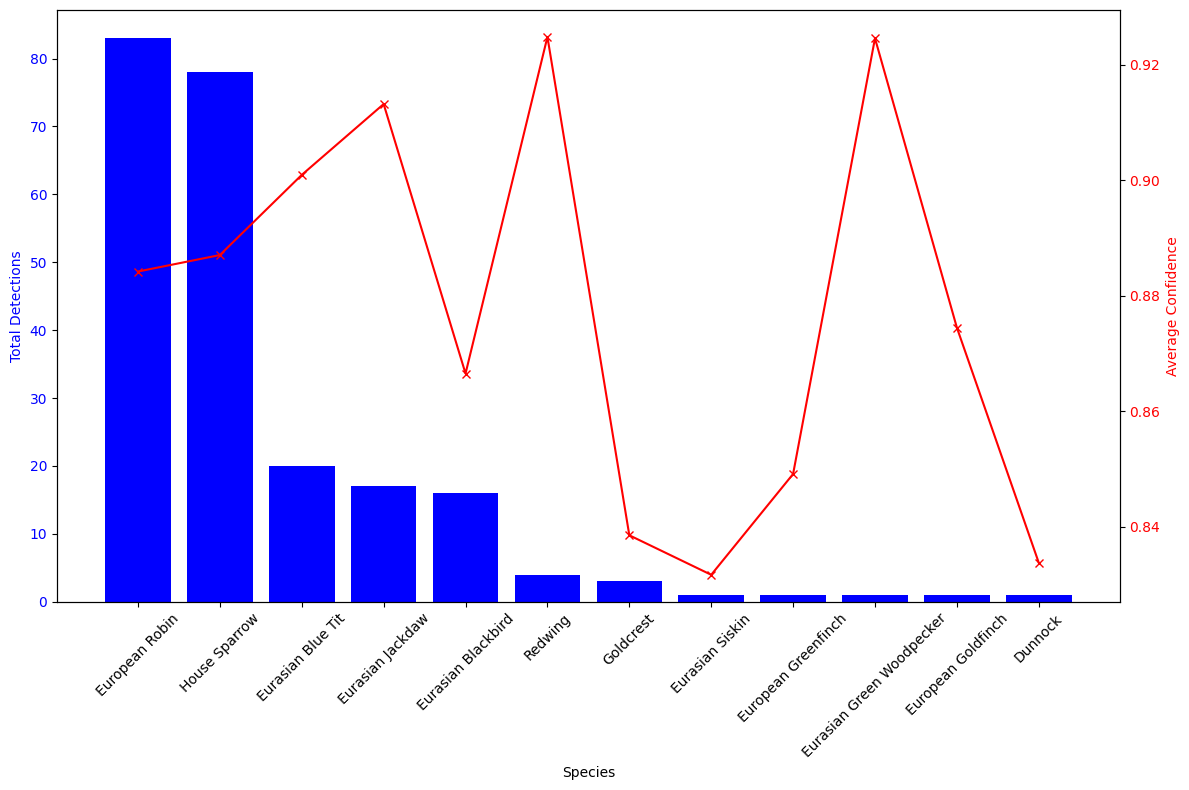

In [ ]:
def plot_results(all_results):
    # Identify all unique species across chunks
    all_species = set()

    # Initialize counters for total occurrences and total confidence for each species
    species_counter = Counter()
    species_confidence = defaultdict(float)

    for results in all_results.values():
        for result in results:
            detections = result['detections']
            for detection in detections:
                common_name = detection['common_name']
                confidence = detection['confidence']

                # Add the species to the set of all species
                all_species.add(common_name)

                # Increment the count and add confidence for the species
                species_counter[common_name] += 1
                species_confidence[common_name] += confidence

    # Calculate average confidence for each species
    avg_confidence = {species: species_confidence[species] / species_counter[species] for species in all_species}

    # Sort species by total occurrences (from high to low)
    sorted_species = sorted(species_counter.items(), key=lambda x: x[1], reverse=True)
    species_names, total_counts = zip(*sorted_species)

    # Get average confidences for sorted species
    avg_confidences = [avg_confidence.get(species, 0) for species in species_names]

    # Plot 2D bar chart
    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax1.bar(species_names, total_counts, color='blue', label='Total Occurrences')
    ax1.set_xlabel('Species')
    ax1.set_xticklabels(species_names, rotation=45)
    ax1.set_ylabel('Total Detections', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(species_names, avg_confidences, 'rx-', label='Average Confidence')
    ax2.set_ylabel('Average Confidence', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.tight_layout()
    plt.show()

# Plot!
plot_results(all_results)


We know how condfident BirdNet is about its results, but how confident are we that it's detected correctly? We can obtain playback samples of different confidence levels per species to 'ground truth' some of its classifications.

Here we build a table for each species with audio playback for BirdNET's most and least confident call per species.

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def calculate_confidence_stats(all_results):
    species_confidence = defaultdict(list)
    for results in all_results.values():
        for result in results:
            detections = result['detections']
            for detection in detections:
                species = detection['common_name']
                confidence = detection['confidence']
                species_confidence[species].append(confidence)

    species_stats = {}
    for species, confidences in species_confidence.items():
        avg_confidence = np.mean(confidences)
        lowest_confidence = min(confidences)
        highest_confidence = max(confidences)
        species_stats[species] = {
            'average_confidence': avg_confidence,
            'lowest_confidence': lowest_confidence,
            'highest_confidence': highest_confidence
        }

    return species_stats

species_stats = calculate_confidence_stats(all_results)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import os
from IPython.display import Audio, display

def generate_spectrograms_df(all_results, wav_files):
    species_data = {}

    for audio_filename, detections_list in all_results.items():
        for chunk_data in detections_list:
            audio_filepath = chunk_data['audio_filepath']
            for detection in chunk_data['detections']:
                common_name = detection['common_name']
                confidence = detection['confidence']
                if audio_filepath:
                    if common_name not in species_data:
                        species_data[common_name] = {'highest_confidence': {'confidence': -np.inf, 'audio_filepath': None}, 'lowest_confidence': {'confidence': np.inf, 'audio_filepath': None}}
                    if confidence > species_data[common_name]['highest_confidence']['confidence']:
                        species_data[common_name]['highest_confidence'] = {'confidence': confidence, 'audio_filepath': audio_filepath}
                    if confidence < species_data[common_name]['lowest_confidence']['confidence']:
                        species_data[common_name]['lowest_confidence'] = {'confidence': confidence, 'audio_filepath': audio_filepath}

    species_spectrograms = {'Species': [], 'Highest_Confidence_Confidence': [], 'Highest_Confidence_Spectrogram': [], 'Lowest_Confidence_Confidence': [], 'Lowest_Confidence_Spectrogram': []}
    for species, data in species_data.items():
        highest_confidence = data['highest_confidence']
        lowest_confidence = data['lowest_confidence']
        if highest_confidence['audio_filepath'] is not None and lowest_confidence['audio_filepath'] is not None:
            species_spectrograms['Species'].append(species)
            species_spectrograms['Highest_Confidence_Confidence'].append(highest_confidence['confidence'])
            species_spectrograms['Highest_Confidence_Spectrogram'].append(highest_confidence['audio_filepath'])
            species_spectrograms['Lowest_Confidence_Confidence'].append(lowest_confidence['confidence'])
            species_spectrograms['Lowest_Confidence_Spectrogram'].append(lowest_confidence['audio_filepath'])

    df = pd.DataFrame(species_spectrograms)
    return df

def plot_spectrograms_with_audio(df, chunk_size=3):
    for index, row in df.iterrows():
        species = row['Species']
        highest_confidence = row['Highest_Confidence_Confidence']
        lowest_confidence = row['Lowest_Confidence_Confidence']
        highest_audio_file = row['Highest_Confidence_Spectrogram']
        lowest_audio_file = row['Lowest_Confidence_Spectrogram']

        # Load audio files
        rate_high, data_high = wavfile.read(highest_audio_file)
        rate_low, data_low = wavfile.read(lowest_audio_file)

        # Plot spectrograms
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f'{species}')

        # Plot highest confidence spectrogram
        axes[0].specgram(data_high, Fs=rate_high)
        axes[0].set_title(f'Highest Confidence (Confidence: {highest_confidence})')
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Frequency')

        # Plot lowest confidence spectrogram
        axes[1].specgram(data_low, Fs=rate_low)
        axes[1].set_title(f'Lowest Confidence (Confidence: {lowest_confidence})')
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Frequency')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust suptitle position
        plt.show()

        # Display audio controls in a table
        display(Audio(data_high[:int(chunk_size * rate_high)], rate=rate_high, autoplay=False))
        display(Audio(data_low[:int(chunk_size * rate_low)], rate=rate_low, autoplay=False))

# Generate DataFrame with highest and lowest confidence detections
df = generate_spectrograms_df(all_results, wav_files)

# Plot spectrograms with audio playback
plot_spectrograms_with_audio(df)


Output hidden; open in https://colab.research.google.com to view.